# Visualization of a Simple Stochastic Gradient Descent using PyTorch DistributedDataParallel

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket
import ipcmagic
%ipcluster start -n 2 --mpi

  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px
import os
import sys
import socket
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils import data

from tqdm.std import trange, tqdm

from line_regression import get_line_data, plot_regression, DynamicRegressionPlot
from torch_utils import seed_everything

## Setup environment for torch.distributed

In [3]:
%%px
# Setup environment for torch.distributed.init_process_group
os.environ['MASTER_PORT'] = '29500'
os.environ['WORLD_SIZE'] = os.environ['SLURM_NNODES']
os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = os.environ['SLURM_NODEID']

In [4]:
master_address = f"'{socket.gethostname()}'"
%px os.environ['MASTER_ADDR'] = $master_address

%px print(os.environ['MASTER_ADDR'])

[stdout:1] nid04611
[stdout:0] nid04611


## Initialize torch.distributed

In [5]:
%%px
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

if not dist.is_initialized():
    # Environment variable initialization
    dist.init_process_group(backend="nccl")

world_size = dist.get_world_size()
rank = dist.get_rank()

print(socket.gethostname(), rank, world_size)

[stdout:1] nid04612 1 2
[stdout:0] nid04611 0 2


## Dataset
Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

In [6]:
%%px
nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

print(ground_truth)

[stdout:0] [2.0, 0.0]
[stdout:1] [2.0, 0.0]


[output:0]

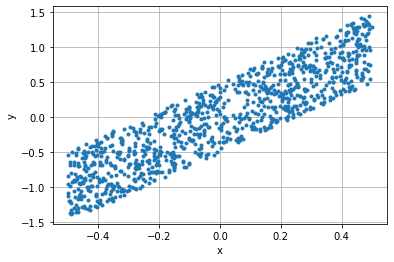

In [7]:
%%px --target 0
plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Input pipeline

In [8]:
%%px
batch_size = 100

# GPU Tensors
device = 'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

dataset = data.TensorDataset(x, y)

### Task 1: Setup the DistributedSampler
### https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler
### to load a subset of the original dataset that is exclusive to each rank
# sampler = data.distributed.DistributedSampler(dataset, rank=dist.get_rank())
loader = data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

#### Inspect sizes:

In [9]:
%%px --target 0
print(dict(dataset_items=len(dataset), batch_size=batch_size, loader_items=len(loader), world_size=world_size))

assert batch_size * len(loader) * world_size == len(dataset)

[stdout:0] {'dataset_items': 1000, 'batch_size': 100, 'loader_items': 5, 'world_size': 2}


## Define distributed model

In [10]:
%%px
model = nn.Linear(1, 1, bias=True, device=device)

### Task 2: wrap the model with DistributedDataParallel (DDP)
### check that all parameters were properly synchronized
### https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html
dist_model = model
# dist_model = DDP(model)

dict(model.named_parameters())

[stderr:1] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.
[stderr:0] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


Out[0:10]: 
{'weight': Parameter containing:
 tensor([[0.4656]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.3907], device='cuda:0', requires_grad=True)}

Out[1:8]: 
{'weight': Parameter containing:
 tensor([[0.4656]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.3907], device='cuda:0', requires_grad=True)}

In [11]:
%%px --noblock -o training
epochs = 1000
lr = 0.0005 * batch_size**0.5
history = []

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

for epoch in trange(epochs, file=sys.__stdout__):
    # Sampler will reshuffle all data every epoch
    sampler.set_epoch(epoch)
    for i, batch in enumerate(loader):
        data, target = batch

        # Calculate loss
        y_hat = dist_model(data)
        mse = F.mse_loss(y_hat, target)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Calculate gradients
        mse.backward()
        # Training step
        optimizer.step()

        history.append([model.weight.item(), model.bias.item(), mse.item()])

<AsyncResult: execute>

In [12]:
# watch the output in real time
from ipcmagic import utilities
utilities.watch_asyncresult(training)

[ stdout 0 ]
100%|██████████| 1000/1000 [00:09<00:00, 106.74it/s]
[ stdout 1 ]
100%|██████████| 1000/1000 [00:09<00:00, 106.74it/s]


[output:1]

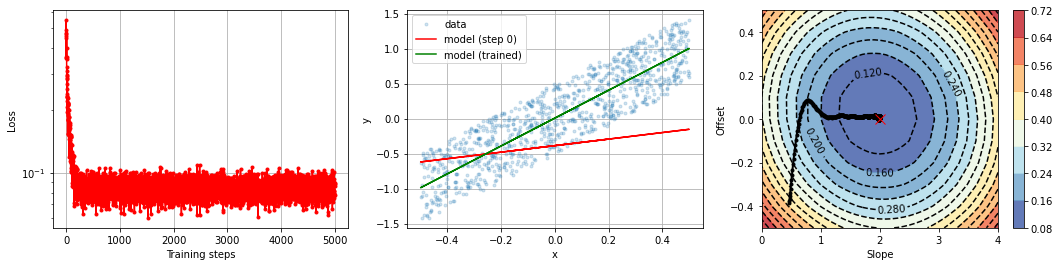

[output:0]

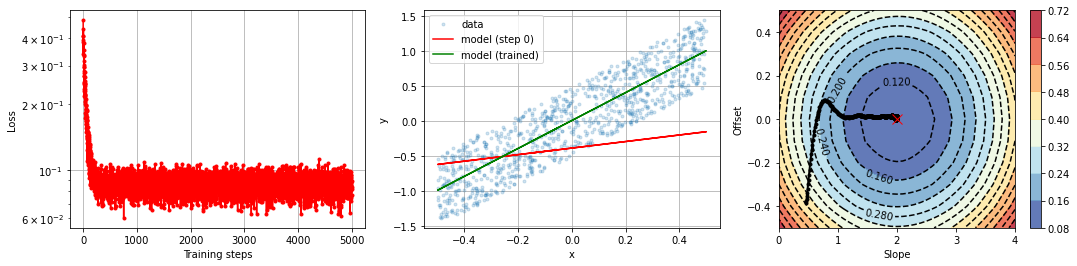

Out[0:12]: 
{'weight': Parameter containing:
 tensor([[1.9916]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([0.0072], device='cuda:0', requires_grad=True)}

Out[1:10]: 
{'weight': Parameter containing:
 tensor([[1.9916]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([0.0072], device='cuda:0', requires_grad=True)}

In [13]:
%%px
plot_regression(history, x_train, y_train, ground_truth)

dict(model.named_parameters())

In [14]:
%ipcluster stop